In [1]:
import sys, os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick   
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
sys.path.append(os.path.abspath('..'))
from ift6758.data.feature_engineering_one import feature_engineering_one

In [2]:
df = feature_engineering_one(years = range(2016, 2021))
df.head(10)

100%|██████████| 6150/6150 [03:39<00:00, 28.02it/s]


,game_id,season,game_time,period,period_time,event_type,team_id,team_name,coordinates_x,coordinates_y,...,goalie,shot_type,empty_net,strength,situation_code,zone_code,distance_to_net,shot_angle,is_goal,is_empty_net
0,2016020001,20162017,2016-10-12 23:00:00+00:00,1,01:11,shot,10,Maple Leafs,-77.0,5.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,13.000000,-1.725255,0,0
1,2016020001,20162017,2016-10-12 23:00:00+00:00,1,02:53,shot,9,Senators,86.0,13.0,...,Frederik Andersen,wrist,False,Even Strength,1551,O,13.341664,-77.005383,0,0
2,2016020001,20162017,2016-10-12 23:00:00+00:00,1,04:01,shot,9,Senators,23.0,-38.0,...,Frederik Andersen,wrist,False,Even Strength,1551,N,76.157731,29.931512,0,0
3,2016020001,20162017,2016-10-12 23:00:00+00:00,1,04:46,shot,9,Senators,33.0,-15.0,...,Frederik Andersen,slap,False,Even Strength,1551,O,57.974132,14.995079,0,0
4,2016020001,20162017,2016-10-12 23:00:00+00:00,1,06:46,shot,10,Maple Leafs,-34.0,28.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,61.717096,-12.824398,0,0
5,2016020001,20162017,2016-10-12 23:00:00+00:00,1,07:30,shot,10,Maple Leafs,-33.0,-17.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,58.523500,7.932758,0,0
6,2016020001,20162017,2016-10-12 23:00:00+00:00,1,08:21,goal,10,Maple Leafs,-70.0,1.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,19.026298,-0.360346,1,0
7,2016020001,20162017,2016-10-12 23:00:00+00:00,1,08:29,shot,10,Maple Leafs,-45.0,-36.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,56.850682,15.037816,0,0
8,2016020001,20162017,2016-10-12 23:00:00+00:00,1,09:00,shot,9,Senators,33.0,-18.0,...,Frederik Andersen,slap,False,Even Strength,1551,O,58.821765,17.818889,0,0
9,2016020001,20162017,2016-10-12 23:00:00+00:00,1,10:16,shot,9,Senators,34.0,20.0,...,Frederik Andersen,wrist,False,Even Strength,1551,O,58.523500,-19.983107,0,0


In [3]:
df_train_val = df[df['season'] < 20202021]
df_test = df[df['season'] == 20202021]

In [4]:
# Default parameters
y = df_train_val['is_goal']
X_temp = df_train_val.drop(columns=['is_goal']).copy()

# Now fill missing values on features only
numerical_cols = X_temp.select_dtypes(include=['number']).columns
median_values = X_temp[numerical_cols].median()
X_temp[numerical_cols] = X_temp[numerical_cols].fillna(median_values)

X = X_temp[['distance_to_net']]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9055


In [5]:
print(pd.Series(y_pred).value_counts())
print(pd.Series(y_val).value_counts())

0    65469
Name: count, dtype: int64
is_goal
0    59282
1     6187
Name: count, dtype: int64


The logistic regression model trained using only distance_to_net achieved 90.5% validation accuracy. However, a closer inspection revealed that the model predicted no goals for all shots.

This is an example of accuracy being misleading in highly imbalanced datasets. Only ~9% of shots are goals in the validation set, so predicting "no goal" for every shot yields similar accuracy.

The main issues are: the severe class imbalance, the limited feature set, and the default prediction threshold. To improve the model, we should add more predictive features and use evaluation metrics that account for imbalance, such as precision, recall, F1-score, or ROC-AUC...

In [6]:
# predict probabilities (taking probability of goal class so [1])
def train_and_predict(X_train, y_train, X_val): 
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_val)[:, 1]
    
    return y_pred_proba, clf

In [7]:
#ROC curve and AUC
def compute_auc_roc(y_val, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.3f}")
    return fpr, tpr, roc_auc

In [8]:
# Percentiles of predicted probabilities
def goal_rate_vs_percentile(y_true, y_pred_proba):
    df_val_percentile = pd.DataFrame({
        'y_true': y_val,
        'y_prob': y_pred_proba
    })

    # Sort highest probability first
    df_val_percentile = df_val_percentile.sort_values(by='y_prob', ascending=False)

    # Assign percentile rank (0 to 100), reversed correctly
    df_val_percentile['percentile'] = np.linspace(100, 0, len(df_val_percentile))

    # Bin into percentiles (e.g., 100 bins)
    df_val_percentile['percentile_bin'] = pd.qcut(df_val_percentile['percentile'], q=100, labels=False)

    # Compute goal rate per percentile
    goal_rate = df_val_percentile.groupby('percentile_bin')['y_true'].mean()
    return goal_rate.index, goal_rate.values

In [9]:
#Cumulative proportion of goals 
def cumulative_goal_curve(y_val, y_pred_proba):
    # DataFrame with true labels + predicted probabilities
    df_val_cum = pd.DataFrame({
        'y_true': y_val,
        'y_prob': y_pred_proba
    })

    # 1. Sort by predicted probability (highest → lowest)
    df_val_cum = df_val_cum.sort_values(by='y_prob', ascending=False).reset_index(drop=True)

    # 2. Compute cumulative number of GOALS encountered as we move down the list
    df_val_cum['cumulative_goals'] = df_val_cum['y_true'].cumsum()

    # 3. Convert cumulative goals to a proportion (%) of all goals
    total_goals = df_val_cum['y_true'].sum()
    df_val_cum['cumulative_goal_percent'] = (df_val_cum['cumulative_goals'] / total_goals) * 100

    # 4. Create percentile axis (100 → 0)
    df_val_cum['percentile'] = np.linspace(100, 0, len(df_val_cum))
    return df_val_cum

In [10]:
# Default parameters
y = df_train_val['is_goal']
X = df_train_val.drop(columns=['is_goal']).copy()
# Now fill missing values on features only
numerical_cols = X.select_dtypes(include=['number']).columns
median_values = X[numerical_cols].median()
X[numerical_cols] = X[numerical_cols].fillna(median_values)

X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


# Model 1
y_pred_proba_1, clf_1 = train_and_predict(X_train[['distance_to_net']] , y_train, X_val[['distance_to_net']])
fpr_1, tpr_1, auc_1 = compute_auc_roc(y_val, y_pred_proba_1)
percentile_1, goal_rate_1 = goal_rate_vs_percentile(y_val, y_pred_proba_1)
df_cumulative_goal_curve_1 = cumulative_goal_curve(y_val, y_pred_proba_1)

#Model 2
y_pred_proba_2, clf_2 = train_and_predict(X_train[['shot_angle']] , y_train, X_val[['shot_angle']])
fpr_2, tpr_2, auc_2 = compute_auc_roc(y_val, y_pred_proba_2)
percentile_2, goal_rate_2 = goal_rate_vs_percentile(y_val , y_pred_proba_2)
df_cumulative_goal_curve_2 = cumulative_goal_curve(y_val, y_pred_proba_2)

#Model 3
y_pred_proba_3, clf_3 = train_and_predict(X_train[['distance_to_net', 'shot_angle']] , y_train, X_val[['distance_to_net', 'shot_angle']])
fpr_3, tpr_3, auc_3 = compute_auc_roc(y_val, y_pred_proba_3)
percentile_3, goal_rate_3 = goal_rate_vs_percentile(y_val, y_pred_proba_3)
df_cumulative_goal_curve_3 = cumulative_goal_curve(y_val, y_pred_proba_3) 

#Model 4
np.random.seed(42)  # so your results are reproducible
y_pred_proba_random = np.random.uniform(0, 1, size=len(y_val))  # same length as validation data
# Compute ROC for Random baseline
fpr_4, tpr_4, auc_4 = compute_auc_roc(y_val, y_pred_proba_random)
percentile_4, goal_rate_4 = goal_rate_vs_percentile(y_val, y_pred_proba_random)
df_cumulative_goal_curve_4 = cumulative_goal_curve(y_val, y_pred_proba_random)

AUC: 0.701
AUC: 0.508
AUC: 0.701
AUC: 0.495


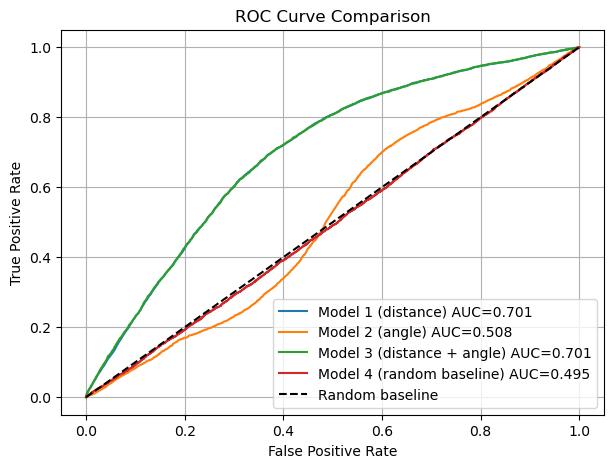

In [11]:
# ROC curve plot and AUC
plt.figure(figsize=(7,5))

plt.plot(fpr_1, tpr_1, label=f"Model 1 (distance) AUC={auc_1:.3f}")
plt.plot(fpr_2, tpr_2, label=f"Model 2 (angle) AUC={auc_2:.3f}")
plt.plot(fpr_3, tpr_3, label=f"Model 3 (distance + angle) AUC={auc_3:.3f}")
plt.plot(fpr_4, tpr_4, label=f"Model 4 (random baseline) AUC={auc_4:.3f}")

# Random classifier baseline
plt.plot([0,1], [0,1], 'k--', label='Random baseline')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

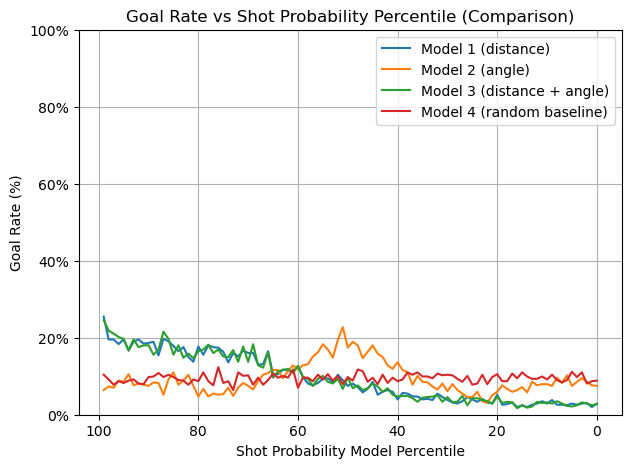

In [12]:
# Goal Rate vs model percentile plot
plt.figure(figsize=(7,5))

plt.plot(percentile_1, goal_rate_1 * 100, label="Model 1 (distance)")
plt.plot(percentile_2, goal_rate_2 * 100, label="Model 2 (angle)")
plt.plot(percentile_3, goal_rate_3 * 100, label="Model 3 (distance + angle)")
plt.plot(percentile_4, goal_rate_4 * 100, label="Model 4 (random baseline)")

plt.gca().invert_xaxis()  # High probability → left side
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim(0, 100)

plt.xlabel("Shot Probability Model Percentile")
plt.ylabel("Goal Rate (%)")
plt.title("Goal Rate vs Shot Probability Percentile (Comparison)")
plt.legend()
plt.grid(True)
plt.show()

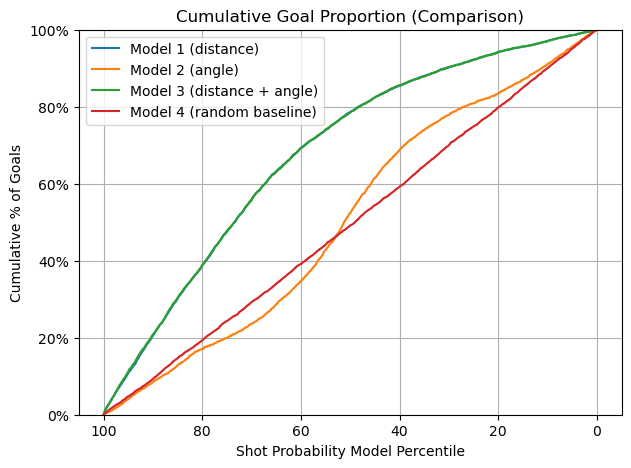

In [14]:
#Cumulative % of goals plot
plt.figure(figsize=(7,5))

plt.plot(df_cumulative_goal_curve_1['percentile'], df_cumulative_goal_curve_1['cumulative_goal_percent'], label="Model 1 (distance)")
plt.plot(df_cumulative_goal_curve_2['percentile'], df_cumulative_goal_curve_2['cumulative_goal_percent'], label="Model 2 (angle)")
plt.plot(df_cumulative_goal_curve_3['percentile'], df_cumulative_goal_curve_3['cumulative_goal_percent'], label="Model 3 (distance + angle)")
plt.plot(df_cumulative_goal_curve_4['percentile'], df_cumulative_goal_curve_4['cumulative_goal_percent'], label="Model 4 (random baseline)")

plt.gca().invert_xaxis()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim(0, 100)

plt.xlabel("Shot Probability Model Percentile")
plt.ylabel("Cumulative % of Goals")
plt.title("Cumulative Goal Proportion (Comparison)")
plt.legend()
plt.grid(True)
plt.show()

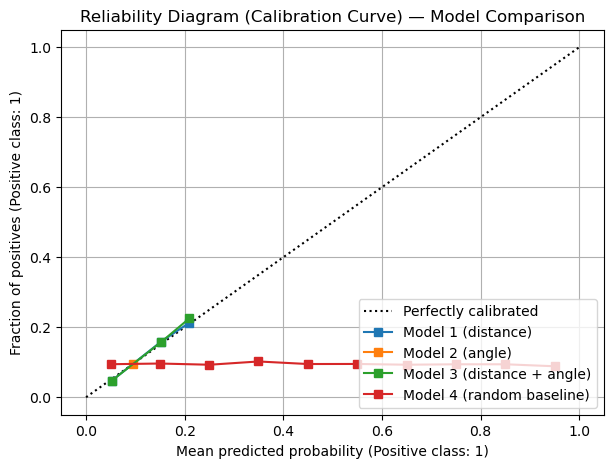

In [15]:
# Reliability diagram comparison plot
plt.figure(figsize=(7,5))

# Model 1 (distance)
CalibrationDisplay.from_predictions(y_val, y_pred_proba_1, n_bins=10, name="Model 1 (distance)", ax=plt.gca())

# Model 2 (angle)
CalibrationDisplay.from_predictions(y_val, y_pred_proba_2, n_bins=10, name="Model 2 (angle)", ax=plt.gca())

# Model 3 (distance + angle)
CalibrationDisplay.from_predictions(y_val, y_pred_proba_3, n_bins=10, name="Model 3 (distance + angle)", ax=plt.gca())

# Model 4 (random baseline)
CalibrationDisplay.from_predictions(y_val, y_pred_proba_random, n_bins=10, name="Model 4 (random baseline)", ax=plt.gca())


plt.title("Reliability Diagram (Calibration Curve) — Model Comparison")
plt.grid(True)
plt.show()

Discussion sur les plots 



In [ ]:
import wandb
wandb.login(relogin=True)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\aniss\_netrc
wandb: Currently logged in as: anissa-djouhri (IFT6758-2025-B1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

: 

: 

: 

In [25]:
#Wandb
import wandb, joblib

# ---- Model 1 (distance only) ----
wandb.init(entity="IFT6758-2025-B1", project="IFT6758-2025-B01", name="model_1_baseline_distance", tags=["baseline", "distance_only"])

wandb.log({"AUC": auc_1})

joblib.dump(clf_1, "model1_baseline_distance.pkl")
artifact = wandb.Artifact("model1_baseline_distance", type="model")
artifact.add_file("model1_baseline_distance.pkl")
wandb.log_artifact(artifact)

wandb.finish()


# ---- Model 2 (angle only) ----
wandb.init(entity="IFT6758-2025-B1", project="IFT6758-2025-B01", name="model_2_baseline_angle", tags=["baseline", "angle_only"])

wandb.log({"AUC": auc_2})

joblib.dump(clf_2, "model2_baseline_angle.pkl")
artifact = wandb.Artifact("model2_baseline_angle", type="model")
artifact.add_file("model2_baseline_angle.pkl")
wandb.log_artifact(artifact)

wandb.finish()


# ---- Model 3 (distance + angle) ----
wandb.init(entity="IFT6758-2025-B1", project="IFT6758-2025-B01", name="model_3_baseline_distance_angle", tags=["baseline", "distance_plus_angle"])

wandb.log({"AUC": auc_3})

joblib.dump(clf_3, "model3_baseline_distance_angle.pkl")
artifact = wandb.Artifact("model3_baseline_distance_angle", type="model")
artifact.add_file("model3_baseline_distance_angle.pkl")
wandb.log_artifact(artifact)

wandb.finish()

AUC,▁
AUC,0.69866


AUC,▁
AUC,0.58769


AUC,▁
AUC,0.70284
